<a href="https://colab.research.google.com/github/cesar-claros/synergistic/blob/master/Fashion_MNIST_cnn_mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install gpytorch

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!cp -r "drive/My Drive/NIPS2020/auxfunc/" .
!cp -r "drive/My Drive/NIPS2020/datasets/" .
!cp -r "drive/My Drive/NIPS2020/style/" .
!cp -r "drive/My Drive/NIPS2020/runs/" .

In [6]:
# %%
# Imports
import io #Used as buffer
import sys
import matplotlib
import tensorflow as tf # Keras model for MNIST 
# matplotlib.use('qt5Agg')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.sigfunc as sgn
import seaborn as sns
import torch
from scipy.stats import entropy, spearmanr
from sklearn import model_selection, svm, ensemble, linear_model, pipeline, \
      tree, neighbors, discriminant_analysis, gaussian_process, preprocessing, impute, decomposition
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
plt.style.use(['ggplot','style/style.mplstyle'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
#%%
# Define classic MLP architecture
def CNN_model(input_dim):
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=input_dim ))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

In [8]:
#%%
# Initialize model
def init_model(input_dim):
    # svm = False
    # model = MLP_model(input_dim=Data_X.shape[1], svm_obj=svm)
    model = CNN_model(input_dim=input_dim)
    loss = tf.keras.losses.categorical_crossentropy
    metric = ['accuracy']
    model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=metric)
    # model.summary()
    return model

In [9]:
#%%
# Signaling function fitting and evaluation
def signalingFunction(X_train, y_train, y_train_pred_th, X_val, y_val, y_val_pred_th, X_test, y_test, y_test_pred_th, kernel='exponential', norm='l01'):
    # X_train, X_val should be scaled
    # Fit signaling function 
    exp = sgn.signaling(norm=norm) # idx = [train,test,val]
    exp.fit(X_train, y_train, y_train_pred_th, kernel=kernel, n_iter=500, lr=0.01)
    table_val = exp.evaluate(X_val, y_val, y_val_pred_th, rule_grid=np.linspace(0,3,30, endpoint=False))
    table_test = exp.test(X_test, y_test, y_test_pred_th, table_val['rule'].to_numpy(), table_val['eta'].to_numpy())
    table = pd.concat([table_val,table_test],axis=1)
    return table, exp

In [10]:
#%%
# Soft and thresholded output predictions
def pred_output(model, X):
    y_pred_soft = model.predict(X)
    y_pred_th = np.argmax(y_pred_soft, axis=1)
    return y_pred_soft, y_pred_th

In [11]:
#%%
# Jaccard similarity index
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [12]:
#%%
# Baseline comparison
def baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp):
      direction = 'further'
      # p_val = np.concatenate(y_val_pred_soft,axis=1)
      crit_val = entropy(y_val_pred_soft, axis=1, base=10)
      # p_test = np.concatenate(y_test_pred_soft,axis=1)
      crit_test = entropy(y_test_pred_soft, axis=1, base=10)
      
      critFunc = sgn.critEvaluation(norm='l01',direction=direction)
      d_val = critFunc.evaluate(y_val, y_val_pred_th, crit_val)
      d_test = critFunc.test(y_test, y_test_pred_th, crit_test, d_val['thresh'].to_numpy())
      crit_table = pd.concat([d_val,d_test],axis=1)

      gamma = table['rule'].to_numpy().reshape(-1,1)
      f_test = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)
      eta = table['eta'].to_numpy().reshape(-1,1)
      theta = crit_table['thresh'].to_numpy().reshape(-1,1)
      if direction == 'closer':
        f_mask, f_idx = np.nonzero(f_test>eta)
      else:
        f_mask, f_idx = np.nonzero(f_test<eta)
      crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)<theta)
      print(list(np.unique(f_mask)))
      print(list(np.unique(crit_mask)))
      print(f_test.shape[0])
      shared = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask))))
      J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan for i in range(f_test.shape[0])]
      # if (list(np.unique(f_mask))==list(np.unique(crit_mask))):
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) for i in np.unique(f_mask)]
      # else:
      #   shared = set(a).intersection(set(b))
      #   union = set(a).union(set(b))
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan  for i in union]
      crit_table['jaccard']=J
      Sp = [spearmanr(f_test[i,:],crit_test)[0] for i in range(f_test.shape[0])]
      crit_table['spearman'] = Sp
      crit_table['gamma'] = gamma
      return crit_table

In [40]:
# For reproducibility
tf.random.set_seed(54321)
np.random.seed(12345)
torch.manual_seed(0)
# %%
# INITIALIZATION
# ==============
# EXPERIMENT SETUP
# ================
# Load data set
(Data_X, Data_y), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# y, y_test = y.astype('int8'), y_test.astype('int8')
# Rescale the images from [0,255] to the [0.0,1.0] range.
Data_X, X_test = Data_X[..., np.newaxis]/255.0, X_test[..., np.newaxis]/255.0
print("Number of original training examples:", len(Data_X))
# reshape the data
# Data_X = Data_X.reshape(60000, 28*28).astype('float32')
# X_test = X_test.reshape(10000, 28*28).astype('float32')
# for keras classification, we need to use `to_categorical` to transform the label to appropriate format
# Data_y = tf.keras.utils.to_categorical(Data_y)
# y_test = tf.keras.utils.to_categorical(y_test)

Number of original training examples: 60000


In [41]:
Data_X, Data_X_sep, Data_y, Data_y_sep = model_selection.train_test_split(Data_X, Data_y, stratify=Data_y, test_size=0.75)
X_test, X_test_sep, y_test, y_test_sep = model_selection.train_test_split(X_test, y_test, stratify=y_test, test_size=0.75)

In [42]:
print(Data_X.shape)
print(X_test.shape)

(15000, 28, 28, 1)
(2500, 28, 28, 1)


In [43]:
#%%
# Assign labels
report_table = []
report_criteria = []
report_plot = []
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=321)
clf = 'softmax'
addPredictions = True
applyPCA = False
accuracy = 0
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)
y_test = tf.keras.utils.to_categorical(y_test)
for train, val in kf.split(Data_X, Data_y):
    X_train = Data_X[train]
    y_train = Data_y[train]
    y_train = tf.keras.utils.to_categorical(y_train)
    X_val = Data_X[val]
    y_val = Data_y[val]
    y_val = tf.keras.utils.to_categorical(y_val)
    
    # sample = sample[:12500]
    # test = test[:2000]
    # X = Data_X[sample]
    # y = Data_y[sample]
    # X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.20, random_state=123)
    # X_test = Data_X[test]
    # y_test = Data_y[test]

    # TRAINING MODEL
    model = init_model(input_dim=Data_X.shape[1:])
    model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=0, validation_data=(X_val, y_val), callbacks=[es])

    y_train_pred_soft, y_train_pred_th = pred_output(model, X_train)
    print('accuracy(Train)={}'.format(np.sum(y_train_pred_th==np.argmax(y_train,axis=1))/y_train_pred_th.size))
    y_val_pred_soft, y_val_pred_th = pred_output(model, X_val)
    y_test_pred_soft, y_test_pred_th = pred_output(model, X_test)

    if clf == 'softmax_act':
            activation_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[5].output)
            X_train_GP = activation_model.predict(X_train)
            X_val_GP = activation_model.predict(X_val)
            X_test_GP = activation_model.predict(X_test)
    elif clf == 'softmax':
            X_train_GP = X_train.reshape(-1,np.prod(X_train.shape[1:]))
            X_val_GP = X_val.reshape(-1,np.prod(X_val.shape[1:]))
            X_test_GP = X_test.reshape(-1,np.prod(X_test.shape[1:]))

    # X_train_GP = X_train.reshape(-1,np.prod(X_train.shape[1:]))
    # X_val_GP = X_val.reshape(-1,np.prod(X_val.shape[1:]))
    # X_test_GP = X_test.reshape(-1,np.prod(X_test.shape[1:]))
    if addPredictions:
            # Add predictions
            X_train_GP = np.concatenate((X_train_GP, y_train_pred_soft), axis=1)
            X_val_GP = np.concatenate((X_val_GP, y_val_pred_soft), axis=1)
            X_test_GP = np.concatenate((X_test_GP, y_test_pred_soft), axis=1)
    scaleX_GP = preprocessing.StandardScaler().fit(np.concatenate((X_train_GP, X_val_GP), axis=0))
    X_train_GP = scaleX_GP.transform(X_train_GP)
    X_val_GP = scaleX_GP.transform(X_val_GP)
    X_test_GP = scaleX_GP.transform(X_test_GP)
    if applyPCA:
            pca_GP = decomposition.PCA(.99).fit(np.concatenate((X_train_GP, X_val_GP), axis=0)) # set percentage of energy preserved by PCA
            # Apply PCA transform to all sets
            X_train_GP = pca_GP.transform(X_train_GP)
            X_val_GP = pca_GP.transform(X_val_GP)
            X_test_GP = pca_GP.transform(X_test_GP)

    table, exp = signalingFunction(X_train_GP, np.argmax(y_train, axis=1), y_train_pred_th, \
                                   X_val_GP, np.argmax(y_val, axis=1), y_val_pred_th,\
                                   X_test_GP, np.argmax(y_test, axis=1), y_test_pred_th)
    report_table.append(table)
    # Baseline for comparison
    crit_table = baselineCriteria(np.argmax(y_val, axis=1), y_val_pred_soft, y_val_pred_th,\
                                  np.argmax(y_test, axis=1), y_test_pred_soft, y_test_pred_th,\
                                  table, exp)
    report_criteria.append(crit_table)

    score = np.sum(np.argmax(y_val, axis=1)==y_val_pred_th)/np.size(np.argmax(y_val, axis=1))
    if accuracy < score:
      accuracy = score
      table_best = table
      crit_table_best = crit_table
      exp_best = exp
      y_test_best = y_test
      y_test_pred_soft_best = y_test_pred_soft
      y_test_pred_th_best = y_test_pred_th
      X_test_best = X_test
    del(model)

accuracy(Train)=0.9344166666666667
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: -0.083  noise: 0.026
Iter 492/500 - Loss: -0.083  noise: 0.026
Iter 493/500 - Loss: -0.083  noise: 0.026
Iter 494/500 - Loss: -0.084  noise: 0.025
Iter 495/500 - Loss: -0.085  noise: 0.025
Iter 496/500 - Loss: -0.086  noise: 0.025
Iter 497/500 - Loss: -0.085  noise: 0.025
Iter 498/500 - Loss: -0.086  noise: 0.025
Iter 499/500 - Loss: -0.086  noise: 0.025
Iter 500/500 - Loss: -0.087  noise: 0.025
evaluating with cuda...
evaluating with cuda...
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
5
Epoch 00006: early stopping
accuracy(Train)=0.9073333333333333
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.044  noise: 0.030
Iter 492/500 - Loss: 0.044  noise: 0.030
Iter 493/500 - Loss: 0.044  noise: 0.030
Iter 494/500 - Loss: 0.042  noise: 0.030
Iter 495/500 - Loss: 0.043  noise: 0.030
Iter 496/500 - Loss: 0.043  noise: 0.030
Iter 497/500 - Loss: 0.042  noise: 0.030
Iter 498/500 - Loss

In [ ]:
logs_base_dir = "runs/"
%tensorboard --logdir {logs_base_dir}

In [44]:
##%
# Boxplot (loss reduction in test set)
report_table_concat = pd.concat(report_table)
cols_table = ['p_value','rho_user','%reduction_test']
df_boxplot_table = pd.DataFrame(report_table_concat[cols_table])
df_boxplot_table['label'] = df_boxplot_table.shape[0]*['$f(x)$']
report_criteria_concat = pd.concat(report_criteria)
columns_crit = ['rho_user','%reduction_test']
df_boxplot_crit = pd.DataFrame(report_criteria_concat[columns_crit])
df_boxplot_crit['label'] = df_boxplot_crit.shape[0]*['$g(x)$']
# p-value median
p_value_col = df_boxplot_table['p_value'] #Add
p_value_by_row_index = df_boxplot_table['p_value'].groupby(df_boxplot_table.index)
p_value_median = p_value_by_row_index.median()
# Boxplot (jaccard index in test set)
columns_jac = ['rho_user','jaccard']
df_jaccard = pd.DataFrame(report_criteria_concat[columns_jac])
# Unfiltered Result dataframes
cols_fx = ['rho_user','%reduction_val','budget','%reduction_test']
results_fx = pd.DataFrame(report_table_concat[cols_fx])
cols_fxgx = ['rho_user','%reduction_test', 'jaccard']
results_fxgx = pd.concat([df_boxplot_table[cols_fxgx[:2]], df_boxplot_crit[cols_fxgx[1]], df_jaccard[cols_fxgx[2]]], axis=1)
# Filter experiments with p_value > 0.05
df_boxplot_crit = df_boxplot_crit.loc[df_boxplot_table['p_value'] <= 0.05]
df_jaccard = df_jaccard.loc[df_boxplot_table['p_value'] <= 0.05]
df_boxplot_table = df_boxplot_table.loc[df_boxplot_table['p_value'] <= 0.05]
# Boxplot with filtered values only
frames = [df_boxplot_table, df_boxplot_crit]
df = pd.concat(frames)

In [45]:
# Avoid plotting when median(p_value)>0.5
for i in range(p_value_median.shape[0]):
    if p_value_median.iloc[i]>0.05:
      df.loc[df.index==i,'%reduction_test'] = np.nan
      df_jaccard.loc[df_jaccard.index==i, 'jaccard'] = np.nan

In [46]:
# Dataframe for results f(x)
results_fx = results_fx.loc[p_value_col <= 0.05].copy()
results_fx_by_row_index = results_fx.groupby(results_fx.index)
fx_median = results_fx_by_row_index.median()
fx_q1 = results_fx_by_row_index.quantile(q=0.25)
fx_q3 = results_fx_by_row_index.quantile(q=0.75)
# Signaling function statistics (median(q1-q3)) LaTex
output_fx = io.StringIO()
numRows = fx_median.shape[0]
numCols = fx_median.shape[1]
output_fx.write("results_fx (\\rho|%reduction_val|sig_rate|%reduction_test|H0)\n")
output_fx.write("----------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==2)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fx_median.iloc[i],fx_q1.iloc[i],fx_q3.iloc[i],range(numCols))]
  output_fx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fx.getvalue())

results_fx (\rho|%reduction_val|sig_rate|%reduction_test|H0)
----------
{} & {} & 0.01 & 7.0(5.2-7.0) & 0.01(0.01-0.01) & 7.0(6.2-7.3) & $\surd$ \\
{} & {} & 0.05 & 25.1(24.5-25.8) & 0.05(0.05-0.05) & 24.2(23.4-26.1) & $\surd$ \\
{} & {} & 0.10 & 42.9(42.5-43.7) & 0.10(0.10-0.10) & 44.6(44.6-45.5) & $\surd$ \\
{} & {} & 0.15 & 59.5(58.6-59.9) & 0.15(0.15-0.15) & 59.5(57.7-60.2) & $\surd$ \\
{} & {} & 0.20 & 73.0(71.3-74.3) & 0.20(0.19-0.21) & 73.0(72.3-73.5) & $\surd$ \\



In [47]:
# Dataframe for comparison f(x)-g(x)
results_fxgx = results_fxgx.loc[p_value_col <= 0.05]
results_fxgx_by_row_index = results_fxgx.groupby(results_fxgx.index)
fxgx_median = results_fxgx_by_row_index.median()
fxgx_q1 = results_fxgx_by_row_index.quantile(q=0.25)
fxgx_q3 = results_fxgx_by_row_index.quantile(q=0.75)
# Baseline comparison statistics (median(q1-q3)) LaTex
output_fxgx = io.StringIO()
numRows = fxgx_median.shape[0]
numCols = fxgx_median.shape[1]
output_fxgx.write("results_fxgx (\\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0\n")
output_fxgx.write("------------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==3)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fxgx_median.iloc[i],fxgx_q1.iloc[i],fxgx_q3.iloc[i],range(numCols))]
  output_fxgx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fxgx.getvalue())

results_fxgx (\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0
------------
{} & {} & 0.01 & 7.0(6.2-7.3) & 5.7(5.3-8.4) & 0.98(0.98-0.99) & $\surd$ \\
{} & {} & 0.05 & 24.2(23.4-26.1) & 22.4(21.4-24.2) & 0.94(0.94-0.94) & $\surd$ \\
{} & {} & 0.10 & 44.6(44.6-45.5) & 41.2(40.9-43.2) & 0.91(0.91-0.92) & $\surd$ \\
{} & {} & 0.15 & 59.5(57.7-60.2) & 60.2(56.5-60.5) & 0.91(0.91-0.92) & $\surd$ \\
{} & {} & 0.20 & 73.0(72.3-73.5) & 72.6(70.6-74.2) & 0.92(0.92-0.92) & $\surd$ \\



In [48]:
#%%
# Save results in csv fomat
path_csv = "drive/My Drive/NIPS2020/results/fashionMNIST/results_{clf}_yhat{yhat}_pca{pca}.csv".format(clf=clf, pca=applyPCA, yhat=addPredictions)
results = pd.concat([results_fx, results_fxgx, p_value_col.loc[p_value_col <= 0.05]], keys=['fx', 'fxgx', ''], axis=1).to_csv(path_csv, index=True, header=True)
# modified output
# Save results in tex fomat
L = [output_fx.getvalue(),output_fxgx.getvalue()]
path_txt = "drive/My Drive/NIPS2020/results/fashionMNIST/results_{clf}_yhat{yhat}_pca{pca}.txt".format(clf=clf, pca=applyPCA, yhat=addPredictions)
txt = open(path_txt, "w") 
txt.writelines(L) 
txt.close() #to change file access modes

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


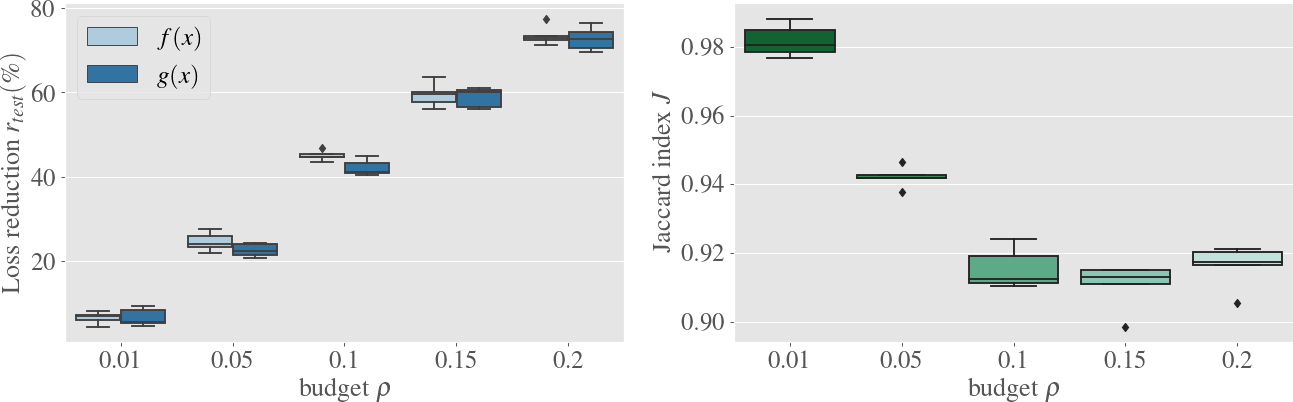

In [49]:
fig, ax = plt.subplots(1,2,figsize=(15, 5.1), constrained_layout=False, dpi=90)
pal = sns.color_palette('Paired')
sns.boxplot(x=df['rho_user'], y=df['%reduction_test'], hue='label', data=df, ax=ax[0], palette=pal)
ax[0].set_xlabel(r'budget $\rho$')
ax[0].set_ylabel(r'Loss reduction $r_{test}(\%)$')
ax[0].legend(loc='upper left')
pal = sns.color_palette('BuGn_r')
sns.boxplot(x=df_jaccard['rho_user'], y=df_jaccard['jaccard'], data=df_jaccard, ax=ax[1], palette=pal)
ax[1].set_xlabel(r'budget $\rho$')
ax[1].set_ylabel(r'Jaccard index $J$')
plt.tight_layout()
path_fig_fxgx = "drive/My Drive/NIPS2020/results/fashionMNIST/fig_fxgx_{clf}_yhat{yhat}_pca{pca}.pdf".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fxgx, bbox_inches='tight', facecolor='w')

In [56]:
rho = 0.15
X_test_best = X_test_best.squeeze()
rule = table_best.loc[table_best.rho_user == rho]['rule'].to_numpy()
eta = table_best.loc[table_best.rho_user == rho]['eta'].to_numpy()[0]
theta = crit_table_best.loc[crit_table_best.rho_user == rho]['thresh'].to_numpy()[0]
f_test = exp_best.gpr_mean_test+rule*np.sqrt(exp_best.gpr_var_test)
top_n = 5 # Top n selected instances in test set
top_f_idx = np.argpartition(f_test, -top_n)[-top_n:]
top_f_idx = top_f_idx[np.argsort(f_test[top_f_idx])[::-1]]# Added
# p_test = np.concatenate((y_test_pred_soft_best,1-y_test_pred_soft_best),axis=1)
crit_test = entropy(y_test_pred_soft_best, axis=1, base=10)
top_crit_idx = np.argpartition(crit_test, -top_n)[-top_n:]
top_crit_idx = top_crit_idx[np.argsort(crit_test[top_crit_idx])[::-1]]# Added

output_text = io.StringIO()
print('eta={:.3f},theta={:.3f}'.format(eta,theta))

eta=0.156,theta=0.306


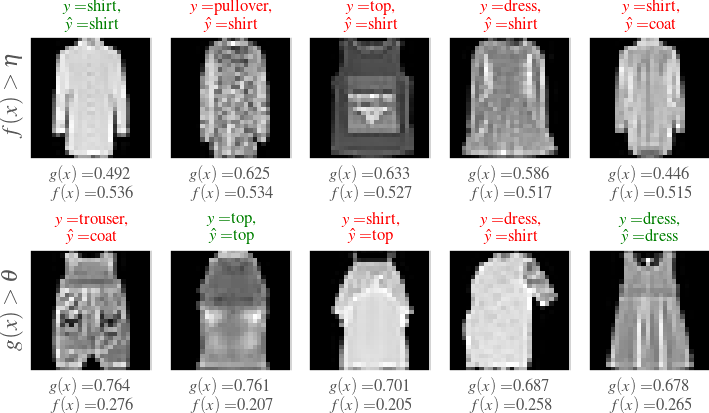

In [73]:
# Plot selected instances
# initialize the label 
labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
# X_test_best = X_test.reshape(-1,28,28)
# y_hat_best = y_test_pred_th[top_f_idx]
# y_th_best = np.argmax(y_test[top_f_idx], axis=1)
# Plot instances
row,col = 2,top_n
fig1, ax = plt.subplots(row, col, figsize=(6.0, 3.5), constrained_layout=True, dpi=120)
# fig1.subplots_adjust(wspace=-0.1, hspace=0.25, top=0.45)
# for i in top_f_idx:
j = 0
for i,k in zip(top_f_idx, top_crit_idx):
    if np.argmax(y_test_best, axis=1)[i] != y_test_pred_th_best[i]:
        color = 'red'
    else:
        color = 'green'
    # ax = fig1.add_subplot(3, 4, j+1)
    ax[0][j].imshow(X_test_best[i, :, :], cmap='gray', interpolation='none')
    ax[0][j].set_title(r'$y=${s1}'.format(s1=labelNames[np.argmax(y_test_best, axis=1)[i]])+',\n'+\
                    r'$\hat{{y}}=${s2}'.format(s2=labelNames[y_test_pred_th_best[i]]), color=color, fontsize=10)
    ax[0][j].set_xlabel(r"$g(x)=${:.3f}".format(crit_test[i])+'\n$f(x)=${:.3f}'.format(f_test[i]), fontsize=10)
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    if np.argmax(y_test_best, axis=1)[k] != y_test_pred_th_best[k]:
        color = 'red'
    else:
        color = 'green'
    # ax = fig1.add_subplot(3, 4, j+1)
    ax[1][j].imshow(X_test_best[k, :, :], cmap='gray', interpolation='none')
    ax[1][j].set_title(r'$y=${s1}'.format(s1=labelNames[np.argmax(y_test_best, axis=1)[k]])+',\n'+\
                    r'$\hat{{y}}=${s2}'.format(s2=labelNames[y_test_pred_th_best[k]]), color=color, fontsize=10)
    ax[1][j].set_xlabel(r"$g(x)=${:.3f}".format(crit_test[k])+'\n$f(x)=${:.3f}'.format(f_test[k]), fontsize=10)
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])
    j = j + 1
# ax[0][0].set_ylabel(r"$f(x)>\eta$"+"\n"+r"$(\eta={:.3f})$".format(eta), fontsize=14)
ax[0][0].set_ylabel(r"$f(x)>\eta$", fontsize=14)
# ax[1][0].set_ylabel(r"$g(x)>\theta$"+"\n"+r"$(\theta={:.3f})$".format(theta), fontsize=14)
ax[1][0].set_ylabel(r"$g(x)>\theta$", fontsize=14)
# fig1.text(0.5, 0.01, r'$\rho={},~|f(x)>\eta|={},~|g(x)>\theta|={}$'.format(rho,np.sum(f_test>eta),np.sum(crit_test>theta)), ha='center', fontsize = 12)
# plt.suptitle(r'Top {} selected instances'.format(top_n), fontsize=15)
# plt.tight_layout()
path_fig_fxgx_test = "drive/My Drive/NIPS2020/results/fashionMNIST/fig_fxgx_test_{clf}_yhat{yhat}_pca{pca}.svg".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fxgx_test, bbox_inches='tight', facecolor='w')